<h1>Table of Contents</h1>
<ul>
  <li><a href="#section1">1. Import Necessary Libraries</a></li>
  <li><a href="#section2">2. Load Data</a></li>
  <li><a href="#section3">3. Data Preprocessing</a></li>
  <li><a href="#section4">4. Define Model Components</a></li>
  <li><a href="#section5">5. Build and Configure Model</a></li>
  <li><a href="#section6">6. Prepare Data Sample</a></li>
  <li><a href="#section7">7. Model Fitting</a></li>
  <li><a href="#section8">8. Visualization and Analysis</a>
    <ul>
      <li><a href="#section8_1">8.1 Model Fit Diagnostics</a></li>
    </ul>
  </li>
</ul>


<a id="section1"></a>
# 1. Import Necessary Libraries

In [57]:
import os
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'  # Disable file validation for smoother execution
os.environ['PYTHONDEVMODE'] = 'off'                  # Turn off Python development mode
import pandas as pd                                  # For data manipulation and analysis
import pyddm                                         # For building and fitting diffusion decision models
from pyddm import Sample                             # To create sample objects for model fitting
import numpy as np                                   # For numerical operations
import pyddm.plot                                    # For plotting model diagnostics (imported first as required)
import matplotlib                                    # For visualization
matplotlib.use('TkAgg')                              # Set matplotlib backend to TkAgg for interactive plotting
import matplotlib.pyplot as plt                      # For creating plots
from IPython.display import Image                    # For displaying images in the notebook

<a id="section2"></a>
# 2. Load Data

In [59]:
# Load and preprocess the data
file_path = '/Users/wangyue/Desktop/data/incon_6Frame/HDDM_InconStim_6Frame.csv'
data_F = pd.read_csv(file_path)

<a id="section3"></a>
# 3. Data Preprocessing

In [61]:
# Select relevant columns for modeling and create a copy to avoid modifying the original data
data_for_model = data_F[['subj_idx', 'trial', 'rt', 'response', 'HSF_emo', 'task']].copy()
# Preserve original categorical columns for reference
data_for_model['task_original'] = data_for_model['task']        # Store original 'task' values
data_for_model['HSF_emo_original'] = data_for_model['HSF_emo']  # Store original 'HSF_emo' values
# Convert categorical variables 'task' and 'HSF_emo' into dummy variables for modeling
data_for_model = pd.get_dummies(data_for_model, columns=['task', 'HSF_emo'], prefix=['task', 'HSF_emo'])

In [62]:
# Display summary statistics of reaction times to understand their distribution
print("Summary statistics of reaction times:")
print(data_for_model['rt'].describe())  # Shows that reaction times are mostly around 2 seconds, with outliers up to ~68 seconds

Summary statistics of reaction times:
count    9750.000000
mean        0.828259
std         0.467399
min         0.010953
25%         0.584762
50%         0.714717
75%         0.909147
max         9.255789
Name: rt, dtype: float64


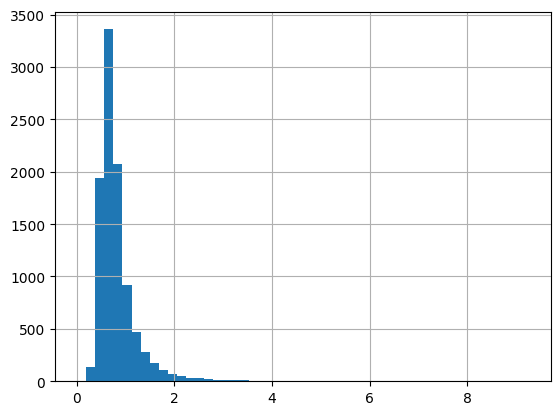

In [63]:
# Visualize the distribution of reaction times with a histogram
%matplotlib inline
data_for_model['rt'].hist(bins=50)
plt.show()

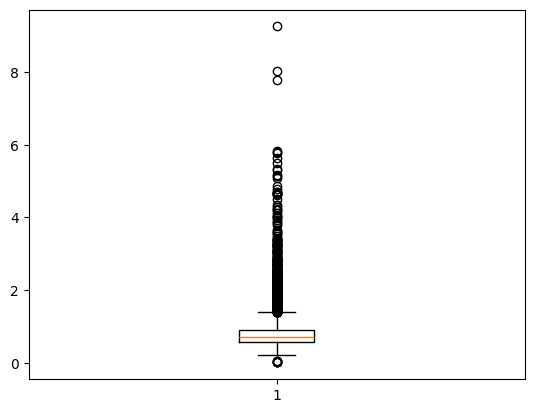

In [64]:
# Use a boxplot to visually confirm the presence of outliers in reaction times
plt.boxplot(data_for_model['rt'])
plt.show()

In [65]:
# Filter out extreme reaction times (rt >= 5 seconds) to improve model fitting
rt_threshold = 5.0
data_for_model_filtered = data_for_model[data_for_model['rt'] < rt_threshold]
print("Summary statistics of filtered reaction times:", data_for_model_filtered['rt'].describe())

Summary statistics of filtered reaction times: count    9737.000000
mean        0.821185
std         0.423111
min         0.010953
25%         0.584603
50%         0.714277
75%         0.908068
max         4.860230
Name: rt, dtype: float64


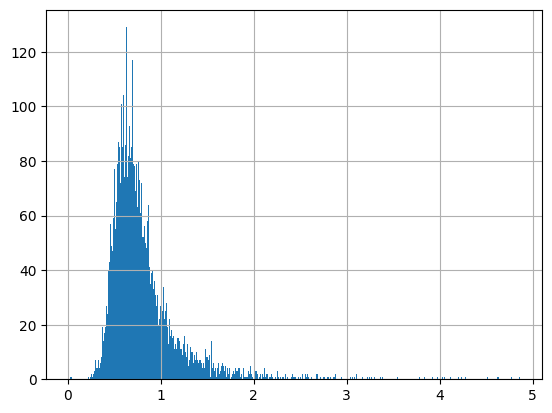

In [66]:
# Visualize the filtered reaction time distribution with a detailed histogram
%matplotlib inline
data_for_model_filtered['rt'].hist(bins=1000)
plt.show()

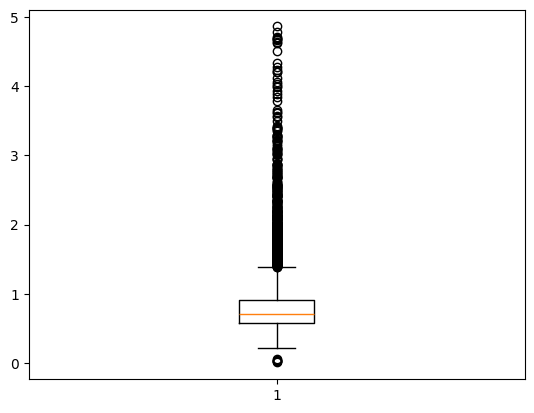

In [67]:
# Use a boxplot to check for remaining outliers in the filtered data
plt.boxplot(data_for_model_filtered['rt'])
plt.show()

<a id="section4"></a>
# 4. Define Model Components

In [69]:
# Define drift function for Model 3, dependent on HSF_emo conditions
def drift_function(HSF_emo_1, HSF_emo_2, drift_emo1, drift_emo2, leak, t, x):
    base_drift = (drift_emo1 * HSF_emo_1 + drift_emo2 * HSF_emo_2)  # Compute base drift based on HSF_emo conditions
    drift = base_drift - leak * x  # Apply leaky integrator to adjust drift
    if np.any(np.isnan(drift)) or np.any(np.isinf(drift)):  # Check for numerical errors (NaN or infinite values)
        print(f"Drift function error: {drift}")
    return drift * np.ones_like(x)  # Ensure output shape matches input x for compatibility with pyDDM


In [70]:
# Define bound function with exponential decay
def bound_function(threshold, invtau, t):
    bound = threshold * np.exp(-t*invtau)  # Calculate exponentially decaying boundary
    if np.any(np.isnan(bound)) or np.any(np.isinf(bound)):  # Check for numerical errors (NaN or infinite values)
        print(f"Bound function error: {bound}")
    return bound

In [71]:
# Define starting position function for Model 3, dependent on task conditions
def starting_position_function(task_1, task_2, task_3, sp1, sp2, sp3):
    starting_position = sp1 * task_1 + sp2 * task_2 + sp3 * task_3  # Compute starting position as a linear combination of task conditions
    if np.any(np.isnan(starting_position)) or np.any(np.isinf(starting_position)):  # Check for numerical errors
        print(f"Starting_position function error: {starting_position}")
    return starting_position

<a id="section5"></a>
# 5. Build and Configure Model

In [73]:
# Build and configure Model 3 with drift dependent on HSF_emo and starting position dependent on task
model_3 = pyddm.gddm(
    drift=drift_function,           # Use the custom HSF_emo-dependent drift function
    noise=1.0,                      # Fixed noise level for the diffusion process
    bound=bound_function,           # Use the custom exponential decay bound function
    nondecision="nt",               # Non-decision time parameter
    starting_position=starting_position_function,  # Use the custom task-dependent starting position function
    parameters={
        "drift_emo1": (0, 2),       # Range for drift parameter under HSF_emo_1 condition
        "drift_emo2": (-2, 0),      # Range for drift parameter under HSF_emo_2 condition
        "threshold": (0.3, 3),      # Range for initial decision threshold
        "sp1": (-0.3, 0.3), "sp2": (-0.3, 0.3), "sp3": (-0.3, 0.3),  # Ranges for starting position parameters for each task condition
        "nt": (0.1, 1),             # Range for non-decision time
        "leak": (0.001, 0.05),      # Range for leak parameter in the integrator
        "invtau": (0.1, 0.8)          # Range for decay rate in the bound function
    },
    conditions=["task_1", "task_2", "task_3", "HSF_emo_1", "HSF_emo_2"],  # Specify task and HSF_emo dummy variables as conditions
    T_dur=5.0  # Simulation duration in seconds
)

<a id="section6"></a>
# 6. Prepare Data Sample

In [75]:
# Convert the filtered DataFrame into a pyDDM Sample object for model fitting
data_sample_filtered = Sample.from_pandas_dataframe(data_for_model_filtered, rt_column_name='rt', choice_column_name='response')

<a id="section7"></a>
# 7. Model Fitting

In [77]:
# Attempt to fit Model 3 to the filtered data sample using BIC loss
try:
    model_3.fit(data_sample_filtered, lossfunction=pyddm.LossBIC, verbose=True)
except Exception as e:
    print(f"Error during Model 3 fitting: {e}")  # Report any fitting errors for debugging
    print(f"Current Model 3 parameters: {model_3.parameters}")  # Display parameters if fitting fails
model_3.show()  # Display the fitted model details

Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.5804055163056876, minval=0, maxval=2), drift_emo2=Fitted(-1.0729306827868044, minval=-2, maxval=0), leak=Fitted(0.02780103417691251, minval=0.001, maxval=0.05)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.6835309648747128, minval=0.3, maxval=3), invtau=Fitted(0.44303321708710197, minval=0.1, maxval=0.8)), IC=ICPointRatioEasy(sp1=Fitted(0.13343209288302596, minval=-0.3, maxval=0.3), sp2=Fitted(-0.2669673062169705, minval=-0.3, maxval=0.3), sp3=Fitted(-0.11950472395378843, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.6792986236840666, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=65241.83975967348
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.4864132582383487, minval=0, maxval=2), drift_emo2=Fitted(-0.47832317616843145, minval=-2, maxval=0), leak=Fitted(0.0015339168766793747, minval=0.001,

differential_evolution step 1: f(x)= 16908.78939227758


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.2063342455174826, minval=0, maxval=2), drift_emo2=Fitted(-0.3144431829419727, minval=-2, maxval=0), leak=Fitted(0.025298120828025725, minval=0.001, maxval=0.05)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(2.337570762206861, minval=0.3, maxval=3), invtau=Fitted(0.41477072236234636, minval=0.1, maxval=0.8)), IC=ICPointRatioEasy(sp1=Fitted(0.16958283921391154, minval=-0.3, maxval=0.3), sp2=Fitted(-0.023435148629329525, minval=-0.3, maxval=0.3), sp3=Fitted(0.2026906682969108, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.23096938904951103, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=49375.67540448462
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(0.9520743979902138, minval=0, maxval=2), drift_emo2=Fitted(-0.9815622598465059, minval=-2, maxval=0), leak=Fitted(0.03717600559790194, minval=0.001, m

differential_evolution step 2: f(x)= 15466.457198271926


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(0.9520743979902138, minval=0, maxval=2), drift_emo2=Fitted(-0.9614647491286568, minval=-2, maxval=0), leak=Fitted(0.046895218457305425, minval=0.001, maxval=0.05)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.6936055729693482, minval=0.3, maxval=3), invtau=Fitted(0.34271927215959186, minval=0.1, maxval=0.8)), IC=ICPointRatioEasy(sp1=Fitted(-0.2685988505284578, minval=-0.3, maxval=0.3), sp2=Fitted(-0.23903921534450306, minval=-0.3, maxval=0.3), sp3=Fitted(-0.09008820319809477, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.17211979629761298, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=26815.86128313634
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.2896113325128487, minval=0, maxval=2), drift_emo2=Fitted(-0.05686385766992741, minval=-2, maxval=0), leak=Fitted(0.03175663687363728, minval=0.001

differential_evolution step 3: f(x)= 15466.457198271926


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.937126148763877, minval=0, maxval=2), drift_emo2=Fitted(-0.11557572871983157, minval=-2, maxval=0), leak=Fitted(0.040917032169085016, minval=0.001, maxval=0.05)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(1.9707353557923595, minval=0.3, maxval=3), invtau=Fitted(0.3704055199182336, minval=0.1, maxval=0.8)), IC=ICPointRatioEasy(sp1=Fitted(-0.04634209215770078, minval=-0.3, maxval=0.3), sp2=Fitted(0.05413893135702306, minval=-0.3, maxval=0.3), sp3=Fitted(0.12433871722648782, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.2705410509351703, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=41386.945929696456
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.5033119867829319, minval=0, maxval=2), drift_emo2=Fitted(-0.05357799613280534, minval=-2, maxval=0), leak=Fitted(0.028267779008886582, minval=0.001,

differential_evolution step 4: f(x)= 15203.445429271205


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(0.36393158829360095, minval=0, maxval=2), drift_emo2=Fitted(-0.680506749776064, minval=-2, maxval=0), leak=Fitted(0.046895218457305425, minval=0.001, maxval=0.05)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.9640366424778649, minval=0.3, maxval=3), invtau=Fitted(0.43933250090365006, minval=0.1, maxval=0.8)), IC=ICPointRatioEasy(sp1=Fitted(-0.18714736637789772, minval=-0.3, maxval=0.3), sp2=Fitted(0.29034509075777476, minval=-0.3, maxval=0.3), sp3=Fitted(0.04800103928268868, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.26237796538669145, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=16553.722809221857
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.3818336755141964, minval=0, maxval=2), drift_emo2=Fitted(-1.0631614912944163, minval=-2, maxval=0), leak=Fitted(0.014127050561123618, minval=0.001

differential_evolution step 5: f(x)= 14621.168973779028


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(0.8679461050752333, minval=0, maxval=2), drift_emo2=Fitted(-0.19815259992581202, minval=-2, maxval=0), leak=Fitted(0.024631847697373036, minval=0.001, maxval=0.05)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.9640366424778649, minval=0.3, maxval=3), invtau=Fitted(0.3965040335279125, minval=0.1, maxval=0.8)), IC=ICPointRatioEasy(sp1=Fitted(-0.06146859452171877, minval=-0.3, maxval=0.3), sp2=Fitted(-0.02261429385811011, minval=-0.3, maxval=0.3), sp3=Fitted(0.04800103928268868, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.26636513370243825, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=14813.342564642337
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.3818336755141964, minval=0, maxval=2), drift_emo2=Fitted(-1.7767168654309493, minval=-2, maxval=0), leak=Fitted(0.02457708990930388, minval=0.001

differential_evolution step 6: f(x)= 14621.168973779028


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(0.600696676464905, minval=0, maxval=2), drift_emo2=Fitted(-0.6116571455301374, minval=-2, maxval=0), leak=Fitted(0.024631847697373036, minval=0.001, maxval=0.05)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(1.0946298846550815, minval=0.3, maxval=3), invtau=Fitted(0.3965040335279125, minval=0.1, maxval=0.8)), IC=ICPointRatioEasy(sp1=Fitted(0.0009743926051904105, minval=-0.3, maxval=0.3), sp2=Fitted(-0.0159156061988456, minval=-0.3, maxval=0.3), sp3=Fitted(-0.16298464788612277, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.147078740511273, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=17366.59281219952
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.9423234118122958, minval=0, maxval=2), drift_emo2=Fitted(-0.03495870478724905, minval=-2, maxval=0), leak=Fitted(0.03386762731553219, minval=0.001, m

differential_evolution step 7: f(x)= 14621.168973779028


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(0.8500637583949875, minval=0, maxval=2), drift_emo2=Fitted(-0.5394404672689348, minval=-2, maxval=0), leak=Fitted(0.016330003624129116, minval=0.001, maxval=0.05)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8373255562809858, minval=0.3, maxval=3), invtau=Fitted(0.2642833481768949, minval=0.1, maxval=0.8)), IC=ICPointRatioEasy(sp1=Fitted(-0.029499964089811856, minval=-0.3, maxval=0.3), sp2=Fitted(0.16470556767529632, minval=-0.3, maxval=0.3), sp3=Fitted(-0.2088292804919351, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.29094440728886706, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=15248.314686616906
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.0998655564035162, minval=0, maxval=2), drift_emo2=Fitted(-0.6140249118476937, minval=-2, maxval=0), leak=Fitted(0.029960330833009412, minval=0.001

differential_evolution step 8: f(x)= 14621.168973779028


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.6367341202483396, minval=0, maxval=2), drift_emo2=Fitted(-0.19815259992581202, minval=-2, maxval=0), leak=Fitted(0.024631847697373036, minval=0.001, maxval=0.05)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.9640366424778649, minval=0.3, maxval=3), invtau=Fitted(0.3965040335279125, minval=0.1, maxval=0.8)), IC=ICPointRatioEasy(sp1=Fitted(-0.2283188321524729, minval=-0.3, maxval=0.3), sp2=Fitted(0.053492101229728715, minval=-0.3, maxval=0.3), sp3=Fitted(0.04800103928268868, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.37662898140011314, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=18529.274799133942
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(0.533845668944603, minval=0, maxval=2), drift_emo2=Fitted(-0.581048683136872, minval=-2, maxval=0), leak=Fitted(0.015208895951213561, minval=0.001, 

differential_evolution step 9: f(x)= 14621.168973779028


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(0.8679461050752333, minval=0, maxval=2), drift_emo2=Fitted(-0.9282004325569937, minval=-2, maxval=0), leak=Fitted(0.024631847697373036, minval=0.001, maxval=0.05)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.9892712924506053, minval=0.3, maxval=3), invtau=Fitted(0.4551547765128181, minval=0.1, maxval=0.8)), IC=ICPointRatioEasy(sp1=Fitted(-0.06146859452171877, minval=-0.3, maxval=0.3), sp2=Fitted(-0.02261429385811011, minval=-0.3, maxval=0.3), sp3=Fitted(0.04800103928268868, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.2491834131023421, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=15871.637703569157
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.1317058944624951, minval=0, maxval=2), drift_emo2=Fitted(-0.8377304963220777, minval=-2, maxval=0), leak=Fitted(0.042749548398506185, minval=0.001,

differential_evolution step 10: f(x)= 14621.168973779028


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(0.6232236607608659, minval=0, maxval=2), drift_emo2=Fitted(-0.18958569878873943, minval=-2, maxval=0), leak=Fitted(0.024631847697373036, minval=0.001, maxval=0.05)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.7782579531881806, minval=0.3, maxval=3), invtau=Fitted(0.38675042365207246, minval=0.1, maxval=0.8)), IC=ICPointRatioEasy(sp1=Fitted(-0.048599526810533235, minval=-0.3, maxval=0.3), sp2=Fitted(-0.02261429385811011, minval=-0.3, maxval=0.3), sp3=Fitted(-0.048980352295795636, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.2978446896727223, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=15466.556236094091
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.5593812690319044, minval=0, maxval=2), drift_emo2=Fitted(-0.6140249118476937, minval=-2, maxval=0), leak=Fitted(0.011664516522720646, minval=0

differential_evolution step 11: f(x)= 14621.168973779028


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.5329338157575767, minval=0, maxval=2), drift_emo2=Fitted(-0.5713252537721369, minval=-2, maxval=0), leak=Fitted(0.024631847697373036, minval=0.001, maxval=0.05)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(1.075890421562991, minval=0.3, maxval=3), invtau=Fitted(0.45401187801349246, minval=0.1, maxval=0.8)), IC=ICPointRatioEasy(sp1=Fitted(-0.02580196747900937, minval=-0.3, maxval=0.3), sp2=Fitted(0.21029392440082578, minval=-0.3, maxval=0.3), sp3=Fitted(0.04800103928268868, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.26636513370243825, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=15919.833168418725
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.3818336755141964, minval=0, maxval=2), drift_emo2=Fitted(-0.12977663031602105, minval=-2, maxval=0), leak=Fitted(0.014127050561123618, minval=0.001

differential_evolution step 12: f(x)= 14493.578827166646


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(0.8679461050752333, minval=0, maxval=2), drift_emo2=Fitted(-0.7267818978153306, minval=-2, maxval=0), leak=Fitted(0.038630824257937395, minval=0.001, maxval=0.05)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8447750745631242, minval=0.3, maxval=3), invtau=Fitted(0.3965040335279125, minval=0.1, maxval=0.8)), IC=ICPointRatioEasy(sp1=Fitted(0.2885922193581797, minval=-0.3, maxval=0.3), sp2=Fitted(0.12135650935653435, minval=-0.3, maxval=0.3), sp3=Fitted(-0.06646979677832525, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.32513473541913973, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=15166.224055314551
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(0.6849184129967653, minval=0, maxval=2), drift_emo2=Fitted(-0.12977663031602105, minval=-2, maxval=0), leak=Fitted(0.04442660755770395, minval=0.001, 

differential_evolution step 13: f(x)= 14493.578827166646


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(0.8679461050752333, minval=0, maxval=2), drift_emo2=Fitted(-0.4805667385716903, minval=-2, maxval=0), leak=Fitted(0.02769886541206079, minval=0.001, maxval=0.05)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.9640366424778649, minval=0.3, maxval=3), invtau=Fitted(0.6199638348688933, minval=0.1, maxval=0.8)), IC=ICPointRatioEasy(sp1=Fitted(-0.14850269347050865, minval=-0.3, maxval=0.3), sp2=Fitted(-0.20556988389730954, minval=-0.3, maxval=0.3), sp3=Fitted(-0.0310729998488114, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.2476856944838705, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=16074.917972366948
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(0.1871143206765804, minval=0, maxval=2), drift_emo2=Fitted(-0.9974143932623658, minval=-2, maxval=0), leak=Fitted(0.021612963909866195, minval=0.001, 

differential_evolution step 14: f(x)= 14493.578827166646


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.6345735493282099, minval=0, maxval=2), drift_emo2=Fitted(-0.3199003840827077, minval=-2, maxval=0), leak=Fitted(0.044904890287858136, minval=0.001, maxval=0.05)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.9640366424778649, minval=0.3, maxval=3), invtau=Fitted(0.41884784224888305, minval=0.1, maxval=0.8)), IC=ICPointRatioEasy(sp1=Fitted(0.08747139803584898, minval=-0.3, maxval=0.3), sp2=Fitted(-0.02261429385811011, minval=-0.3, maxval=0.3), sp3=Fitted(-0.09249675878427079, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.30926549366643524, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=15286.00908801647
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.079854635556053, minval=0, maxval=2), drift_emo2=Fitted(-0.6210417980998861, minval=-2, maxval=0), leak=Fitted(0.04442660755770395, minval=0.001, 

differential_evolution step 15: f(x)= 14493.578827166646


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.1176100573355061, minval=0, maxval=2), drift_emo2=Fitted(-0.8140357083059542, minval=-2, maxval=0), leak=Fitted(0.04045580929274022, minval=0.001, maxval=0.05)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.9640366424778649, minval=0.3, maxval=3), invtau=Fitted(0.3965040335279125, minval=0.1, maxval=0.8)), IC=ICPointRatioEasy(sp1=Fitted(-0.0640219482789728, minval=-0.3, maxval=0.3), sp2=Fitted(0.14689150995684916, minval=-0.3, maxval=0.3), sp3=Fitted(0.07338269900111997, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.2758269117287867, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=15129.30377565793
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.9704780554209638, minval=0, maxval=2), drift_emo2=Fitted(-0.30395219085890623, minval=-2, maxval=0), leak=Fitted(0.03537856341765726, minval=0.001, max

differential_evolution step 16: f(x)= 14409.940550028998


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(0.8679461050752333, minval=0, maxval=2), drift_emo2=Fitted(-0.3721005744620942, minval=-2, maxval=0), leak=Fitted(0.025988708790678175, minval=0.001, maxval=0.05)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.9640366424778649, minval=0.3, maxval=3), invtau=Fitted(0.3965040335279125, minval=0.1, maxval=0.8)), IC=ICPointRatioEasy(sp1=Fitted(-0.17182829133760735, minval=-0.3, maxval=0.3), sp2=Fitted(-0.07259719845658115, minval=-0.3, maxval=0.3), sp3=Fitted(0.08599034798764495, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.3425182617905543, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=16957.557168046762
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(0.8591388145271697, minval=0, maxval=2), drift_emo2=Fitted(-0.12977663031602105, minval=-2, maxval=0), leak=Fitted(0.04442660755770395, minval=0.001,

differential_evolution step 17: f(x)= 14347.605756114566


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.9585905981690104, minval=0, maxval=2), drift_emo2=Fitted(-0.1489854423087007, minval=-2, maxval=0), leak=Fitted(0.030958021271886786, minval=0.001, maxval=0.05)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.9640366424778649, minval=0.3, maxval=3), invtau=Fitted(0.3965040335279125, minval=0.1, maxval=0.8)), IC=ICPointRatioEasy(sp1=Fitted(-0.06198286697062357, minval=-0.3, maxval=0.3), sp2=Fitted(0.010212787307519067, minval=-0.3, maxval=0.3), sp3=Fitted(-0.15845632200067397, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.26636513370243825, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=15881.854132355422
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(0.6021551244802084, minval=0, maxval=2), drift_emo2=Fitted(-0.12977663031602105, minval=-2, maxval=0), leak=Fitted(0.009246312474724391, minval=0.0

differential_evolution step 18: f(x)= 14347.605756114566


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(0.9981120198966718, minval=0, maxval=2), drift_emo2=Fitted(-0.38635860729620575, minval=-2, maxval=0), leak=Fitted(0.024631847697373036, minval=0.001, maxval=0.05)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.7828300319663735, minval=0.3, maxval=3), invtau=Fitted(0.3965040335279125, minval=0.1, maxval=0.8)), IC=ICPointRatioEasy(sp1=Fitted(-0.19553512151872418, minval=-0.3, maxval=0.3), sp2=Fitted(-0.19183751939187288, minval=-0.3, maxval=0.3), sp3=Fitted(0.02357386143693767, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.3184110307247958, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=15690.8308598693
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.3052120391315152, minval=0, maxval=2), drift_emo2=Fitted(-0.598751057847793, minval=-2, maxval=0), leak=Fitted(0.02720905015546921, minval=0.001, ma

differential_evolution step 19: f(x)= 14347.605756114566


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(0.8679461050752333, minval=0, maxval=2), drift_emo2=Fitted(-0.45959023918523423, minval=-2, maxval=0), leak=Fitted(0.0027268335081544574, minval=0.001, maxval=0.05)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8726983002254064, minval=0.3, maxval=3), invtau=Fitted(0.3215233556542282, minval=0.1, maxval=0.8)), IC=ICPointRatioEasy(sp1=Fitted(0.07554372705155445, minval=-0.3, maxval=0.3), sp2=Fitted(0.10272725256492889, minval=-0.3, maxval=0.3), sp3=Fitted(0.07060612852258616, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.36488745476747314, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=15660.383389553946
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.0668642067566172, minval=0, maxval=2), drift_emo2=Fitted(-0.24988568666767752, minval=-2, maxval=0), leak=Fitted(0.005443834293118, minval=0.001, 

differential_evolution step 20: f(x)= 14347.605756114566


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(0.8679461050752333, minval=0, maxval=2), drift_emo2=Fitted(-0.3267408357364012, minval=-2, maxval=0), leak=Fitted(0.02041162044920588, minval=0.001, maxval=0.05)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8366957330703967, minval=0.3, maxval=3), invtau=Fitted(0.3348698914516244, minval=0.1, maxval=0.8)), IC=ICPointRatioEasy(sp1=Fitted(0.10945152889029942, minval=-0.3, maxval=0.3), sp2=Fitted(0.0015615574795241115, minval=-0.3, maxval=0.3), sp3=Fitted(0.04800103928268868, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.26636513370243825, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=15163.513470031965
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.3052120391315152, minval=0, maxval=2), drift_emo2=Fitted(-0.19388227838110317, minval=-2, maxval=0), leak=Fitted(0.02720905015546921, minval=0.001,

differential_evolution step 21: f(x)= 14337.093905965807


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(0.8679461050752333, minval=0, maxval=2), drift_emo2=Fitted(-0.4062488864741325, minval=-2, maxval=0), leak=Fitted(0.029018800856259935, minval=0.001, maxval=0.05)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8953599007814579, minval=0.3, maxval=3), invtau=Fitted(0.3366202853217716, minval=0.1, maxval=0.8)), IC=ICPointRatioEasy(sp1=Fitted(0.014361574149270483, minval=-0.3, maxval=0.3), sp2=Fitted(-0.02261429385811011, minval=-0.3, maxval=0.3), sp3=Fitted(0.04800103928268868, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.2939331412451423, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=14601.49712496671
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(0.9256483942193858, minval=0, maxval=2), drift_emo2=Fitted(-0.2670645877490254, minval=-2, maxval=0), leak=Fitted(0.022386044706522442, minval=0.001, 

differential_evolution step 22: f(x)= 14322.667636976408


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.0398057691366893, minval=0, maxval=2), drift_emo2=Fitted(-0.5133913069088569, minval=-2, maxval=0), leak=Fitted(0.0015916874130717587, minval=0.001, maxval=0.05)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8949265559308291, minval=0.3, maxval=3), invtau=Fitted(0.5399628811390728, minval=0.1, maxval=0.8)), IC=ICPointRatioEasy(sp1=Fitted(0.06190809233798175, minval=-0.3, maxval=0.3), sp2=Fitted(0.14629013625236834, minval=-0.3, maxval=0.3), sp3=Fitted(-0.01334128983345657, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.3050089657144466, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=14522.067620833765
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.1062741621497234, minval=0, maxval=2), drift_emo2=Fitted(-0.48487003932868755, minval=-2, maxval=0), leak=Fitted(0.016562750172247453, minval=0.001

differential_evolution step 23: f(x)= 14322.667636976408
Polishing solution with 'L-BFGS-B'


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.0176421306604788, minval=0, maxval=2), drift_emo2=Fitted(-0.4171034719244222, minval=-2, maxval=0), leak=Fitted(0.0060436130575553595, minval=0.001, maxval=0.05)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.894620791062411, minval=0.3, maxval=3), invtau=Fitted(0.43874952388370275, minval=0.1, maxval=0.8)), IC=ICPointRatioEasy(sp1=Fitted(0.0318398261934554, minval=-0.3, maxval=0.3), sp2=Fitted(0.0630654797048733, minval=-0.3, maxval=0.3), sp3=Fitted(0.004795325459374422, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.3006418259188996, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=14322.66763746951
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.0176421206604789, minval=0, maxval=2), drift_emo2=Fitted(-0.4171034619244222, minval=-2, maxval=0), leak=Fitted(0.0060436130575553595, minval=0.001, m

Model information:
Choices: 'correct' (upper boundary), 'error' (lower boundary)
Drift component DriftEasy:
    easy_drift
    Fitted parameters:
    - drift_emo1: 1.010232
    - drift_emo2: -0.413959
    - leak: 0.005970
Noise component NoiseConstant:
    constant
    Fixed parameters:
    - noise: 1.000000
Bound component BoundEasy:
    easy_bound
    Fitted parameters:
    - threshold: 0.890000
    - invtau: 0.436117
IC component ICPointRatioEasy:
    easy_starting_point
    Fitted parameters:
    - sp1: 0.031840
    - sp2: 0.063065
    - sp3: 0.004795
Overlay component OverlayChain:
    Overlay component OverlayNonDecision:
        Add a non-decision by shifting the histogram
        Fitted parameters:
        - nondectime: 0.300642
    Overlay component OverlayUniformMixture:
        Uniform distribution mixture model
        Fixed parameters:
        - umixturecoef: 0.020000
Fit information:
    Loss function: BIC
    Loss function value: 14320.989060462116
    Fitting method: di

In [78]:
# Display the fitted model details
model_3.show()

Model information:
Choices: 'correct' (upper boundary), 'error' (lower boundary)
Drift component DriftEasy:
    easy_drift
    Fitted parameters:
    - drift_emo1: 1.010232
    - drift_emo2: -0.413959
    - leak: 0.005970
Noise component NoiseConstant:
    constant
    Fixed parameters:
    - noise: 1.000000
Bound component BoundEasy:
    easy_bound
    Fitted parameters:
    - threshold: 0.890000
    - invtau: 0.436117
IC component ICPointRatioEasy:
    easy_starting_point
    Fitted parameters:
    - sp1: 0.031840
    - sp2: 0.063065
    - sp3: 0.004795
Overlay component OverlayChain:
    Overlay component OverlayNonDecision:
        Add a non-decision by shifting the histogram
        Fitted parameters:
        - nondectime: 0.300642
    Overlay component OverlayUniformMixture:
        Uniform distribution mixture model
        Fixed parameters:
        - umixturecoef: 0.020000
Fit information:
    Loss function: BIC
    Loss function value: 14320.989060462116
    Fitting method: di

<a id="section8"></a>
# 8. Visualization and Analysis

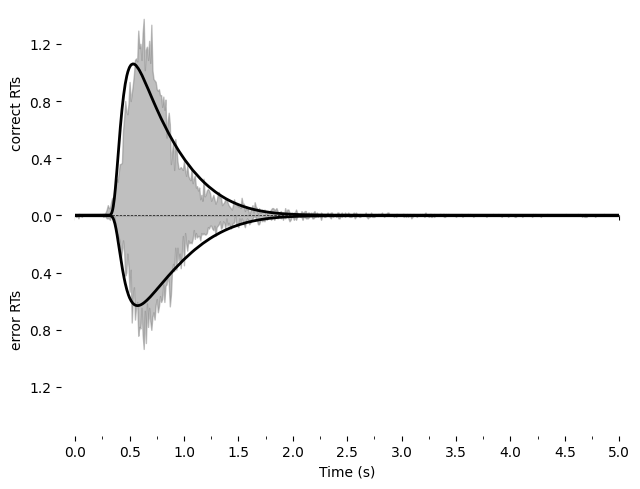

In [80]:
# Visualize fit diagnostics for Model 3 to evaluate performance
%matplotlib inline
pyddm.plot.plot_fit_diagnostics(model=model_3, sample=data_sample_filtered)
plt.show()